# Make datasets for cell locations

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

## UniProt: GO cellular components

In [2]:
df_cl = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations.tsv", sep="\t")
df_cl["Gene Ontology (cellular component)"] = df_cl["Gene Ontology (cellular component)"].fillna(value="")
df_cl["Gene Ontology (cellular component)"] = df_cl["Gene Ontology (cellular component)"].str.lower()

# Filter
df_cl = df_cl[
    (df_cl["Organism"] == "Homo sapiens (Human)") &
    (df_cl["Gene Names (primary)"].notna())
]
display(df_cl.head(3))

# df_cl_names = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprot_cell_locations_names_2025_11_13.tsv", sep="\t")
# cl_names = list(df_cl_names.Name.unique())
# cl_names = sorted([loc.lower() for loc in cl_names])

# display(df_cl_names)
# print(cl_names)


,Entry,Reviewed,Gene Names (primary),Organism,Gene Ontology (cellular component),Subcellular location [CC],Length,Sequence
0,A0A087X1C5,reviewed,CYP2D7,Homo sapiens (Human),cytoplasm [go:0005737]; intracellular membrane...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,515,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
1,A0A0B4J2F0,reviewed,PIGBOS1,Homo sapiens (Human),mitochondrial outer membrane [go:0005741]; mit...,SUBCELLULAR LOCATION: Mitochondrion outer memb...,54,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
2,A0A0C5B5G6,reviewed,MT-RNR1,Homo sapiens (Human),extracellular space [go:0005615]; mitochondrio...,SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...,16,MRWQEMGYIFYPRKLR


In [ ]:
# import re
# import pandas as pd

# def extract_locations(text):
#     """Simple extraction of subcellular locations"""
#     if pd.isna(text) or not text.strip():
#         return []
    
#     # 1. Split by "SUBCELLULAR LOCATION: " and take first
#     if 'SUBCELLULAR LOCATION:' not in text:
#         return []
#     parts = text.split('SUBCELLULAR LOCATION:')
#     text = parts[1] if len(parts) > 1 else parts[0]
    
#     # 2. Remove notes
#     text = re.sub(r'Note=.*$', '', text, flags=re.DOTALL)
    
#     # 3. Check if there are brackets [*] - if yes, skip this entry
#     if re.search(r'\[[^\]]+\]:', text):
#         return []
    
#     # 4. Remove {} evidence codes
#     text = re.sub(r'\{[^}]+\}', '', text)
    
#     # 5. Split by "."
#     locations = text.split('.')
    
#     # 6. Split each element by comma and flatten
#     all_locations = []
#     for loc in locations:
#         loc = loc.strip()
#         if loc:
#             # Split by comma
#             sub_locs = [s.strip() for s in loc.split(',') if s.strip()]
#             all_locations.extend(sub_locs)
    
#     return all_locations

# # Usage
# df_cl['locations'] = df_cl['Subcellular location [CC]'].apply(extract_locations)
# print(df_cl[['Entry', 'locations']].head(10))

# print(df_cl[df_cl.Entry=="O43155"].locations.to_list())


        Entry                                          locations
0  A0A087X1C5  [Membrane ; Multi-pass membrane protein, Cytop...
1  A0A0B4J2F0  [Mitochondrion outer membrane ; Single-pass me...
2  A0A0C5B5G6                 [Secreted, Mitochondrion, Nucleus]
3  A0A0K2S4Q6                                                 []
4  A0A0U1RRE5                                [Cytoplasm, P-body]
5  A0A1B0GTW7   [Membrane ; Single-pass type I membrane protein]
6      A0AV02           [Membrane ; Multi-pass membrane protein]
7      A0AV96                               [Nucleus, Cytoplasm]
8      A0AVF1                          [Cell projection, cilium]
9      A0AVI4  [Endoplasmic reticulum membrane ; Multi-pass m...
[['Cell membrane ; Single-pass membrane protein', 'Endoplasmic reticulum membrane', 'Cell junction', 'focal adhesion', 'Secreted', 'extracellular space', 'extracellular matrix', 'Microsome membrane', 'Secreted', 'Synapse', 'synaptosome']]


,Entry,Reviewed,Gene Names (primary),Organism,Gene Ontology (cellular component),Subcellular location [CC],Length,Sequence,locations,n_locations
0,A0A087X1C5,reviewed,CYP2D7,Homo sapiens (Human),cytoplasm [go:0005737]; intracellular membrane...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,515,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"{intracellular membrane-bounded organelle, mem...",4
1,A0A0B4J2F0,reviewed,PIGBOS1,Homo sapiens (Human),mitochondrial outer membrane [go:0005741]; mit...,SUBCELLULAR LOCATION: Mitochondrion outer memb...,54,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"{mitochondrial outer membrane, mitochondrion}",2
2,A0A0C5B5G6,reviewed,MT-RNR1,Homo sapiens (Human),extracellular space [go:0005615]; mitochondrio...,SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...,16,MRWQEMGYIFYPRKLR,"{mitochondrion, extracellular space, nucleus}",3
3,A0A0K2S4Q6,reviewed,CD300H,Homo sapiens (Human),extracellular region [go:0005576]; plasma memb...,SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...,201,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,"{plasma membrane, extracellular region}",2
4,A0A0U1RRE5,reviewed,NBDY,Homo sapiens (Human),p-body [go:0000932],"SUBCELLULAR LOCATION: Cytoplasm, P-body {ECO:0...",68,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,{p-body},1
...,...,...,...,...,...,...,...,...,...,...
20403,Q9H8Q6,reviewed,HEXA-AS1,Homo sapiens (Human),,NaN,139,MTGKNVYFQSQLEAFHCLQYELFPSRLTINLLVTTHIPFPQTKPHI...,{},0
20406,Q9NRI7,reviewed,PPY2P,Homo sapiens (Human),,NaN,21,MAAACRCLSLLLLSTCVALLL,{},0
20407,Q9NZ38,reviewed,IDI2-AS1,Homo sapiens (Human),,NaN,188,MAFPGQSDTKMQWPEVPALPLLSSLCMAMVRKSSALGKEVGRRSEG...,{},0
20410,Q9P1J3,reviewed,DHRS4-AS1,Homo sapiens (Human),,NaN,65,MSEQNICNQKDKSTLPFCQAHLCEETTNRLCVSNKAVYSLECKWAE...,{},0


7143    {plasma membrane, cytoplasmic side of mitochon...
Name: locations, dtype: object

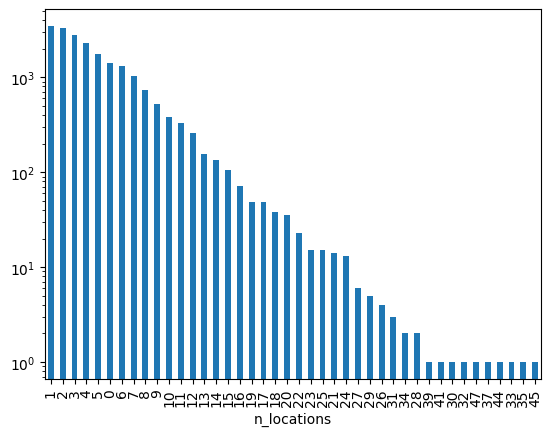

In [3]:
locations = []

for locs in df_cl["Gene Ontology (cellular component)"]:

    #print(locs)

    if locs == "":
        locations.append(set())
        continue

    locs = locs.split("; ")
    #print(locs)

    locs = [l.split(" [")[0] for l in locs]

    #print(locs)

    locations.append(set(locs))

df_cl["locations"] = locations
df_cl["n_locations"] = df_cl["locations"].apply(len)

display(df_cl)

df_cl["n_locations"].value_counts().plot(kind="bar", logy=True)
df_cl[df_cl["n_locations"] == 45].locations

All locations:  1824
{'ciliary transition fiber', 'parkin-fbxw7-cul1 ubiquitin ligase complex', 'heterochromatin', 'katanin complex', 'perinuclear endoplasmic reticulum lumen', 'bcor complex', 'cbm complex', 'striated muscle myosin thick filament', 'high-density lipoprotein particle', 'axonemal b tubule inner sheath', 'serine-type peptidase complex', 'gamma-delta t cell receptor complex', 'cilium', 'slik (saga-like) complex', 'nbaf complex', 'cak-ercc2 complex', 'nuclear pore outer ring', 'ercc4-ercc1 complex', 'growth cone leading edge', 'integrin alpha8-beta1 complex', 'laminin-10 complex', 'traf2-gstp1 complex', 'rough endoplasmic reticulum membrane', 't cell receptor complex', 'peroxisome', 'matrix side of mitochondrial inner membrane', 'meprin a complex', 'trna (m1a) methyltransferase complex', 'noc1p-noc2p complex', 'granular vesicle', 'titin-telethonin complex', 'dolichyl-phosphate-mannose-protein mannosyltransferase complex', 'ruffle membrane', 'growth cone lamellipodium', 'mon

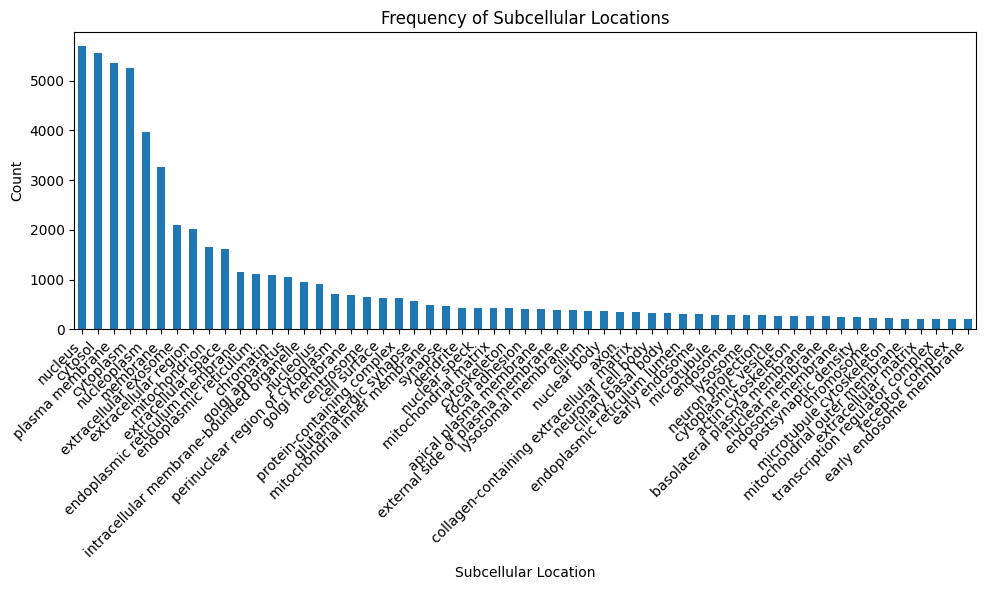

In [4]:
# All locations
all_locations = set().union(*df_cl["locations"])
print("All locations: ", len(all_locations))
print(all_locations)

# How porteins per location
MIN_PROTEIN_PER_LOCATION = 200
all_locations_list = [loc for locs in df_cl["locations"] for loc in locs]
len(all_locations_list)
counts = pd.Series(all_locations_list).value_counts()
counts = counts[counts>=MIN_PROTEIN_PER_LOCATION]
allowed_locations = set(counts.index)
print("Allowed locations: ", len(allowed_locations))
print(allowed_locations)

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
plt.title("Frequency of Subcellular Locations")
plt.xlabel("Subcellular Location")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
# save processed df
df_cl.to_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations_formatted.csv", index=False)

## Create dataset Location

- Need to pass resulting csv to `02_makedataset.ipynb`
- Take also prot with multiple locations

In [ ]:
LOCATION = "nucleus"

df_location = df_cl[
    #(df["n_location"] == 1) &
    (df_cl["locations"].apply(lambda x: len(set([LOCATION]).intersection(x)) != 0 )) 
    ].copy()

df_location = df_location[["Entry", "Length", "locations", "Gene Names (primary)", "n_locations", "Sequence"]].rename(columns={"Entry": "protein", "Gene Names (primary)": "gene", "Sequence": "sequence"})
df_location["geneset_count"] = 1 # costant (sample with same probavility)
df_location["definitive_positive"] = 1

display(df_location)
df_location["definitive_positive"].value_counts()

,protein,Length,locations,gene,n_locations,sequence,geneset_count,definitive_positive
2,A0A0C5B5G6,16,"{mitochondrion, extracellular space, nucleus}",MT-RNR1,3,MRWQEMGYIFYPRKLR,1,1
7,A0AV96,593,"{nucleus, cytoplasm, apolipoprotein b mrna edi...",RBM47,3,MTAEDSTAAMSSDSAAGSSAKVPEGVAGAPNEAALLALMERTGYSM...,1,1
11,A0AVT1,1052,"{cytosol, cytoplasm, nucleus}",UBA6,3,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,1,1
14,A0JLT2,244,"{nucleoplasm, nucleus, core mediator complex, ...",MED19,4,MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPP...,1,1
25,A1A519,330,{nucleus},FAM170A,1,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,1,1
...,...,...,...,...,...,...,...,...
20033,Q9NUC0,356,{nucleus},SERTAD4,1,MTLVLSMNRFCEPIVSEGAAEIAGYQTLWEADSYGGPSPPGPAQAP...,1,1
20038,Q9NWW7,574,"{nucleoplasm, nucleus}",C2orf42,2,MEPNSLRTKVPAFLSDLGKATLRGIRKCPRCGTYNGTRGLSCKNKT...,1,1
20054,Q9UHQ7,104,{nucleus},TCEAL9,1,MKSCQKMEGKPENESEPKHEEEPKPEEKPEEEEKLEEEAKAKGTFR...,1,1
20068,Q9Y5V0,76,"{cytoplasm, nucleus}",ZNF706,2,MARGQQKIQSQQKNAKKQAGQKKKQGHDQKAAAKAALIYTCTVCRT...,1,1


definitive_positive
1    5684
Name: count, dtype: int64

In [ ]:
# Save
df_location.to_csv(f"/home/gdallagl/myworkdir/ESMSec/data/cell_location/{LOCATION}_02_positive_proteins.csv", index=False)

---

## Secreted Proteins (no multiple locations)

With csv, run 02_makedataset.ipynb

In [62]:
df_secreted = df[
    #(df["n_location"] == 1) &
    (df["location"].apply(lambda x: len(set(["Secreted"]).intersection(x)) != 0 )) 
    ].copy()

df_secreted = df_secreted[["Entry", "Length", "location", "Gene Names (primary)", "n_location", "Sequence"]].rename(columns={"Entry": "protein", "Gene Names (primary)": "gene", "Sequence": "sequence"})
df_secreted["geneset_count"] = 1 # costant (sample with same probavility)
df_secreted["definitive_positive"] = df_secreted["n_location"].apply(lambda x: x == 1) # the False will be sondiered ambigues and thus removeed on the o2_makedataset scirpt

display(df_secreted)
df_secreted["definitive_positive"].value_counts()



,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive
2,A0A0C5B5G6,16,"{Mitochondrion, Nucleus, Secreted}",MT-RNR1,3,MRWQEMGYIFYPRKLR,1,False
3,A0A0K2S4Q6,201,"{Secreted, Membrane}",CD300H,2,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,1,False
17,A0M8Q6,106,"{Cell membrane, Secreted}",IGLC7,2,GQPKAAPSVTLFPPSSEELQANKATLVCLVSDFNPGAVTVAWKADG...,1,False
28,A1E959,279,"{Cytoplasm, Nucleus, Secreted}",ODAM,3,MKIIILLGFLGATLSAPLIPQRLMSASNSNELLLNLNNGQLLPLQL...,1,False
30,A1KZ92,1463,"{Cell membrane, Cytoplasm, Secreted, Endoplasm...",PXDNL,4,MEPRLFCWTTLFLLAGWCLPGLPCPSRCLCFKSTVRCMHLMLDHIP...,1,False
...,...,...,...,...,...,...,...,...
20071,S4R3P1,24,"{Cytoplasm, Secreted}",MTRNR2L13,2,MDTQGFSCLLLLISEIDLSVKRRI,1,False
20072,S4R3Y5,24,"{Cytoplasm, Secreted}",MTRNR2L11,2,MATRGFSCLLLVISEIDLSVKRWV,1,False
20123,A0A411D538,79,{Secreted},SCPPPQ1,1,MKFLILAGLLSTATALPIPLEQYAESSSEQRFIFYPPQVPPFFPQV...,1,True
20135,A6NC62,81,{Secreted},RBAKDN,1,MWPPLLLLLLLLPAAPVPTAKAAPHPDANTQEGLQNLLQGVGAGGD...,1,True


definitive_positive
False    1139
True      970
Name: count, dtype: int64

In [63]:
print(df_secreted[df_secreted["definitive_positive"] == True].protein.to_list())

['A8K2U0', 'O00175', 'O00187', 'O00292', 'O00300', 'O00339', 'O00585', 'O00622', 'O00626', 'O14594', 'O14625', 'O14791', 'O14793', 'O15041', 'O15123', 'O15130', 'O15204', 'O15232', 'O15263', 'O15444', 'O15467', 'O15520', 'O43240', 'O43320', 'O43827', 'O43854', 'O43897', 'O43915', 'O43927', 'O60258', 'O60383', 'O60565', 'O75093', 'O75094', 'O75462', 'O75556', 'O75610', 'O75629', 'O75636', 'O75888', 'O76061', 'O76076', 'O76093', 'O94813', 'O94907', 'O94919', 'O95388', 'O95390', 'O95393', 'O95399', 'O95407', 'O95428', 'O95445', 'O95460', 'O95715', 'O95750', 'O95813', 'O95965', 'O95968', 'O95972', 'O95998', 'O96009', 'P00450', 'P00709', 'P00738', 'P00739', 'P00740', 'P00742', 'P00746', 'P00747', 'P00748', 'P00749', 'P00995', 'P01011', 'P01019', 'P01023', 'P01033', 'P01034', 'P01036', 'P01037', 'P01127', 'P01148', 'P01178', 'P01185', 'P01189', 'P01213', 'P01215', 'P01222', 'P01225', 'P01229', 'P01236', 'P01241', 'P01242', 'P01258', 'P01266', 'P01270', 'P01275', 'P01282', 'P01286', 'P01298',

In [64]:
df_secreted.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/secreted_01_positive_proteins.csv", index=False)

## Lysosome (no multiple locations)

With csv, run 02_makedataset.ipynb

In [24]:
df_lyso = df[
    #(df["location"].apply(lambda x: len(set(["Lysosome lumen", "Lysosome membrane", "Lysosome"]).intersection(x)) != 0 )) &
    (df["location"].apply(lambda x: len(set(["Lysosome lumen", "Lysosome"]).intersection(x)) != 0 )) &
    (df["n_location"] == 1) 
    ]

df_lyso = df_lyso[["Entry", "Length", "location", "Gene Names (primary)", "n_location", "Sequence"]].rename(columns={"Entry": "protein", "Gene Names (primary)": "gene", "Sequence": "sequence"})
df_lyso["geneset_count"] = 1 # costant
df_lyso["definitive_positive"] = True # costant

print(df_lyso.shape)
df_lyso.sort_values("gene").head(10)



(40, 8)


,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive
2714,P13686,325,{Lysosome},ACP5,1,MDMWTALLILQALLLPSLADGATPALRFVAVGDWGGVPNAPFHTAR...,1,True
3126,P20933,346,{Lysosome},AGA,1,MARKSNLPVLLVPFLLCQALVRCSSPLPLVVNTWPFKNATEAAWRA...,1,True
15020,P51689,593,{Lysosome},ARSD,1,MRSAARRGRAAPAARDSLPVLLFLCLLLKTCEPKTANAFKPNILLI...,1,True
10448,Q96EG1,525,{Lysosome},ARSG,1,MGWLFLKVLLAGVSFSGFLYPLVDFCISGKTRGQKPNFVIILADDM...,1,True
15107,Q01459,385,{Lysosome},CTBS,1,MSRPQLRRWRLVSSPPSGVPGLALLALLALLALRLAAGTDCPCPEP...,1,True
2538,P10619,480,{Lysosome},CTSA,1,MIRAAPPPLFLLLLLLLLLVSWASRGEAAPDQDEIQRLPGLAKQPS...,1,True
4617,P53634,463,{Lysosome},CTSC,1,MGAGPSLLLAALLLLLSGDGAVRCDTPANCTYLDLLGTWVFQVGSS...,1,True
13470,Q9UBX1,484,{Lysosome},CTSF,1,MAPWLQLLSLLGLLPGAVAAPAQPRAASFQAWGPPSPELLAPTRFA...,1,True
2393,P09668,335,{Lysosome},CTSH,1,MWATLPLLCAGAWLLGVPVCGAAELCVNSLEKFHFKSWMSKHRKTY...,1,True
4066,P43234,321,{Lysosome},CTSO,1,MDVRALPWLPWLLWLLCRGGGDADSRAPFTPTWPRSREREAAAFRE...,1,True


In [25]:
df_lyso.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/lyso_01_positive_proteins.csv", index=False)

## Lyso Vs Secreted

NOOOOO need for 02_makeDataset.ipynb

In [29]:
df_lyso.loc[:, "label"] = 1 # costant
df_secreted.loc[:, "label"] = 0 # costant

data = pd.concat([df_lyso, df_secreted])

# Remove ambigous from secretedS
data = data[data.definitive_positive == True]

data["geneset_count"] = 1 # costant

data

,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive,label
190,O00115,360,{Lysosome},DNASE2,1,MIPLLLAALLCVPAGALTCYGDSGQPVDWFVVYKLPALRGSGEAAQ...,1,True,1
289,O00462,879,{Lysosome},MANBA,1,MRLHLLLLLALCGAGTTAAELSYSLRGNWSICNGNGSLELPGAVPG...,1,True,1
346,O00754,1011,{Lysosome},MAN2B1,1,MGAYARASGVCARGCLDSAGPWTMSRALRPPLPPLCFFLLLLAAAG...,1,True,1
1096,O60911,334,{Lysosome},CTSV,1,MNLSLVLAAFCLGIASAVPKFDQNLDTKWYQWKATHRRLYGANEEG...,1,True,1
2032,P04066,466,{Lysosome},FUCA1,1,MRAPGMRSRPAGPALLLLLLFLGAAESVRRAQPPRRYTPDWPSLDS...,1,True,1
...,...,...,...,...,...,...,...,...,...
20008,Q9H7B7,122,{Secreted},PKD1L1-AS1,1,MGFHFCIWIIFLLPPPCKKCLSPPTMNLRPPKSCGNVFYWVLVLNS...,1,True,0
20027,Q9NRI6,33,{Secreted},PYY2,1,MATVLLALLVYLGALVDAYPIKPEAPGEDAFLG,1,True,0
20123,A0A411D538,79,{Secreted},SCPPPQ1,1,MKFLILAGLLSTATALPIPLEQYAESSSEQRFIFYPPQVPPFFPQV...,1,True,0
20135,A6NC62,81,{Secreted},RBAKDN,1,MWPPLLLLLLLLPAAPVPTAKAAPHPDANTQEGLQNLLQGVGAGGD...,1,True,0


In [30]:
from sklearn.model_selection import train_test_split

# Stratified split by label
train_clusters, temp_clusters = train_test_split(
    data,
    test_size=0.2,
    stratify=data['label'],
    random_state=42
)
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_clusters['label'],
    random_state=42
)

train_prots = train_clusters["protein"].to_list()
val_prots = val_clusters["protein"].to_list()
test_prots = test_clusters["protein"].to_list()

test_prots
data['set'] = ["train" if p in train_prots else "val" if p in val_prots else "test" for p in data["protein"]]
data.loc[data[data.set == "val"].index[1:], "set"] = "test"  # just to have more

# Check split distribution 
print(data.groupby('set')['label'].value_counts().unstack(fill_value=0)) 
display(data)


label    0   1
set           
test   194   7
train  776  32
val      0   1


,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive,label,set
190,O00115,360,{Lysosome},DNASE2,1,MIPLLLAALLCVPAGALTCYGDSGQPVDWFVVYKLPALRGSGEAAQ...,1,True,1,train
289,O00462,879,{Lysosome},MANBA,1,MRLHLLLLLALCGAGTTAAELSYSLRGNWSICNGNGSLELPGAVPG...,1,True,1,train
346,O00754,1011,{Lysosome},MAN2B1,1,MGAYARASGVCARGCLDSAGPWTMSRALRPPLPPLCFFLLLLAAAG...,1,True,1,train
1096,O60911,334,{Lysosome},CTSV,1,MNLSLVLAAFCLGIASAVPKFDQNLDTKWYQWKATHRRLYGANEEG...,1,True,1,val
2032,P04066,466,{Lysosome},FUCA1,1,MRAPGMRSRPAGPALLLLLLFLGAAESVRRAQPPRRYTPDWPSLDS...,1,True,1,test
...,...,...,...,...,...,...,...,...,...,...
20008,Q9H7B7,122,{Secreted},PKD1L1-AS1,1,MGFHFCIWIIFLLPPPCKKCLSPPTMNLRPPKSCGNVFYWVLVLNS...,1,True,0,train
20027,Q9NRI6,33,{Secreted},PYY2,1,MATVLLALLVYLGALVDAYPIKPEAPGEDAFLG,1,True,0,test
20123,A0A411D538,79,{Secreted},SCPPPQ1,1,MKFLILAGLLSTATALPIPLEQYAESSSEQRFIFYPPQVPPFFPQV...,1,True,0,train
20135,A6NC62,81,{Secreted},RBAKDN,1,MWPPLLLLLLLLPAAPVPTAKAAPHPDANTQEGLQNLLQGVGAGGD...,1,True,0,train


In [32]:
data.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/lyso-secreted_02_dataset.csv", index=False)

# CD-CODE Cell condensates (no multiple locations)

Multi class dataset

In [47]:
# Load Allowed proteins (reviewed unirpot)
uniprot = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/human_proteome.tsv", sep="\t")

# only reviewd
uniprot = uniprot[uniprot.Reviewed == "reviewed"]

# Rename
uniprot = uniprot[["Entry", "Sequence"]].rename(columns={"Entry": "protein", "Sequence": "sequence"})

uniprot

,protein,sequence
0,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
1,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
2,A0A0C5B5G6,MRWQEMGYIFYPRKLR
3,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...
4,A0A0U1RRE5,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...
...,...,...
20400,Q9UI25,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...
20401,Q9UI54,MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...
20402,Q9UI72,MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...
20403,Q9Y3F1,MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...


In [49]:
# oad ocndesate locations
df = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/protein_in_condensates_CD-CODE.tsv", sep="\t")

# Only allowed proteins
df = df[df.uniprotkb_ac.isin(uniprot.protein.to_list())]

# Drop proteins in MULTIPLE locations
df = df.drop_duplicates(subset=["uniprotkb_ac"], keep=False)
display(df[df.duplicated(subset=["uniprotkb_ac"], keep=False)].sort_values(by="uniprotkb_ac")) # check for duoslaictes

# condenste with at least 100 proteins
allowed_condensates = df.condensate_name.value_counts()[df.condensate_name.value_counts() >= 50].index.to_list()
display(df.condensate_name.value_counts()[df.condensate_name.value_counts() >= 50])
print(allowed_condensates)

# Filter
df = df[(df.condensate_name.isin(allowed_condensates))]

display(df)


,uniprotkb_ac,condensate_id,condensate_name


condensate_name
Presynaptic clusters and postsynaptic densities    886
Nucleolus                                          602
Centrosome                                         326
Stress granule                                     243
P-body                                              74
Nuclear speckle                                     71
PML body                                            66
Name: count, dtype: int64

['Presynaptic clusters and postsynaptic densities', 'Nucleolus', 'Centrosome', 'Stress granule', 'P-body', 'Nuclear speckle', 'PML body']


,uniprotkb_ac,condensate_id,condensate_name
1264,Q14164,B5B9A610,PML body
1265,P27694,B5B9A610,PML body
1266,P61956,B5B9A610,PML body
1268,P01023,B5B9A610,PML body
1270,P15408,B5B9A610,PML body
...,...,...,...
10358,P30837,91857CE7,Nucleolus
10359,P61313,91857CE7,Nucleolus
10476,Q32NC0,91857CE7,Nucleolus
10477,Q86VY4,91857CE7,Nucleolus


In [51]:
#protein	sequence	label	set

condensate_to_int = {
    name: idx 
    for idx, name in enumerate(df['condensate_name'].unique())
}

df['label'] = df['condensate_name'].map(condensate_to_int)


df = df.rename(columns={"uniprotkb_ac": "protein"}).merge(uniprot)

df

,protein,condensate_id,condensate_name,label,sequence
0,Q14164,B5B9A610,PML body,0,MQSTANYLWHTDDLLGQGATASVYKARNKKSGELVAVKVFNTTSYL...
1,P27694,B5B9A610,PML body,0,MVGQLSEGAIAAIMQKGDTNIKPILQVINIRPITTGNSPPRYRLLM...
2,P61956,B5B9A610,PML body,0,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...
3,P01023,B5B9A610,PML body,0,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...
4,P15408,B5B9A610,PML body,0,MYQDYPGNFDTSSRGSSGSPAHAESYSSGGGGQQKFRVDMPGSGSA...
...,...,...,...,...,...
2263,P30837,91857CE7,Nucleolus,6,MLRFLAPRLLSLQGRTARYSSAAALPSPILNPDIPYNQLFINNEWQ...
2264,P61313,91857CE7,Nucleolus,6,MGAYKYIQELWRKKQSDVMRFLLRVRCWQYRQLSALHRAPRPTRPD...
2265,Q32NC0,91857CE7,Nucleolus,6,MRQKHYLEAAARGLHDSCPGQARYLLWAYTSSHDDKSTFEETCPYC...
2266,Q86VY4,91857CE7,Nucleolus,6,MSGRSRGRKSSRAKNRGKGRAKARVRPAPDDAPRDPDPSQYQSLGE...


In [52]:
from sklearn.model_selection import train_test_split

# Stratified split by label
train_clusters, temp_clusters = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_clusters['label'],
    random_state=42
)

train_prots = train_clusters["protein"].to_list()
val_prots = val_clusters["protein"].to_list()
test_prots = test_clusters["protein"].to_list()

test_prots
df['set'] = ["train" if p in train_prots else "val" if p in val_prots else "test" for p in df["protein"]]
df.loc[df[df.set == "val"].index[1:], "set"] = "test"  # just to have more

# Check split distribution 
print(df.groupby('set')['label'].value_counts().unstack(fill_value=0)) 
display(df)


label   0   1    2   3    4    5    6
set                                  
test   12  14   65  15  177   49  121
train  53  57  261  59  709  194  481
val     1   0    0   0    0    0    0


,protein,condensate_id,condensate_name,label,sequence,set
0,Q14164,B5B9A610,PML body,0,MQSTANYLWHTDDLLGQGATASVYKARNKKSGELVAVKVFNTTSYL...,train
1,P27694,B5B9A610,PML body,0,MVGQLSEGAIAAIMQKGDTNIKPILQVINIRPITTGNSPPRYRLLM...,train
2,P61956,B5B9A610,PML body,0,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...,train
3,P01023,B5B9A610,PML body,0,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,train
4,P15408,B5B9A610,PML body,0,MYQDYPGNFDTSSRGSSGSPAHAESYSSGGGGQQKFRVDMPGSGSA...,train
...,...,...,...,...,...,...
2263,P30837,91857CE7,Nucleolus,6,MLRFLAPRLLSLQGRTARYSSAAALPSPILNPDIPYNQLFINNEWQ...,train
2264,P61313,91857CE7,Nucleolus,6,MGAYKYIQELWRKKQSDVMRFLLRVRCWQYRQLSALHRAPRPTRPD...,train
2265,Q32NC0,91857CE7,Nucleolus,6,MRQKHYLEAAARGLHDSCPGQARYLLWAYTSSHDDKSTFEETCPYC...,train
2266,Q86VY4,91857CE7,Nucleolus,6,MSGRSRGRKSSRAKNRGKGRAKARVRPAPDDAPRDPDPSQYQSLGE...,train


In [53]:
df[df.duplicated(subset=["protein"], keep=False)].sort_values(by="protein")

,protein,condensate_id,condensate_name,label,sequence,set


In [54]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/condensate_02_dataset.csv", index=False)